In [0]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.5.0.html

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from functools import reduce
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader, InMemoryDataset

import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('running on '+ ("GPU" if torch.cuda.is_available() else "CPU"))

running on CPU


In [0]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/rubber'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def loss_file_search(mypath):
  losses_files = [f for f in listdir(mypath) if ("losses" in f)]
  for loss_file in losses_files:
    losses = np.load(join(mypath, loss_file), allow_pickle=True)
    training_loss = np.array(losses.tolist()['losses']).T[0]
    plt.plot(training_loss)
    #loss_analysis(losses)
  
  directories = [f for f in listdir(mypath) if os.path.isdir(join(mypath, f))]
  for directory in directories:
    loss_file_search(mypath+'/'+directory)

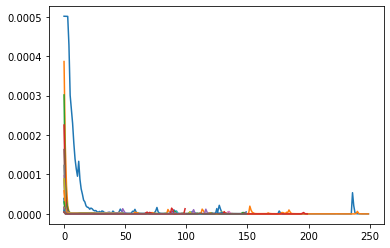

In [0]:
root = PATH+'/models_rnn/kkk'
#ylim(top=5.08, bottom=5.07)#, ylim_bottom=5.0
loss_file_search(root)

In [0]:
def get_all_directories(mypath):  
  directories= [f for f in listdir('/'+mypath) if os.path.isdir(join(mypath, f))]
  for directory in directories:
    get_all_directories(directory)
    #loss_file_search(mypath+'/'+directory)

#get_all_directories(PATH)

In [0]:
def loss_analysis(losses):
 print('loss analysis') 

In [0]:
import torch
import torch.nn as nn
from torch import optim

class RNNModel(nn.Module):
    def __init__(self, input_size, parameter_sizes, repeats ,output_size):
        super(RNNModel, self).__init__()
        self.input_size = input_size
        self.repeater_input_size = parameter_sizes[0]
        self.hidden_size = parameter_sizes[1]
        self.repeats = repeats
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, self.repeater_input_size)
        self.relu_activation = nn.ReLU()

        self.layers = dict()

        
        k = 0
        for i in range(repeats):
          i = i+k
          self.layers['fc_'+str(i)] = nn.Linear(self.repeater_input_size, self.hidden_size)
          self.layers['gru_'+str(i+1)] = nn.GRU(self.hidden_size, self.hidden_size)
          self.layers['fc_'+str(i+2)] = nn.Linear(self.hidden_size, self.repeater_input_size)
          k+=2

        self.module_list = nn.ModuleDict(self.layers)

        self.fc2 = nn.Linear(self.repeater_input_size, output_size)
        
    def forward(self, input, hidden):
      output = self.fc1(input)
      output = self.relu_activation(output)

      k = 0
      for i in range(self.repeats):
        i = i+k
        output = self.layers['fc_'+str(i)](output)
        output = self.relu_activation(output)

        output, hidden[i-k] = self.layers['gru_'+str(i+1)](output, hidden[i-k])#should be different. check the nlp page
        output = self.relu_activation(output)
        hidden[i-k] = self.relu_activation(hidden[i-k])

        output = self.layers['fc_'+str(i+2)](output)
        output = self.relu_activation(output)
        k +=2

      output = self.fc2(output)
      #output = self.relu_activation(output)

      return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [0]:
class Seq2SeqDataSet(InMemoryDataset):
    def __init__(self, root, input_sequence, output_sequence, transform=None, pre_transform=None):
        super(Seq2SeqDataSet, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
      if os.path.exists(self.root+PROCESSED_DIR):
        return self.root+CLEANED_DIR #'/cleaned'
      else:
        os.mkdir(self.root+PROCESSED_DIR)
        return self.root+CLEANED_DIR#'/cleaned'
        
    @property
    def processed_dir(self):
      if os.path.exists(self.root+PROCESSED_DIR):
        return self.root+PROCESSED_DIR
      else:
        os.mkdir(self.root+PROCESSED_DIR)
        return self.root+PROCESSED_DIR

    @property
    def raw_file_names(self):
      mypath = self.raw_dir
      filenames = [f for f in listdir(mypath) if isfile(join(mypath, f))]
      return filenames

    @property
    def processed_file_names(self):
        return ['processed.dt']

    def download(self):
        pass
    
    def process(self):
      output_size , output_sequence_len, input_sequence_len= configuration['output_size'],\
      configuration['output_sequence_len'],\
      configuration['input_sequence_len'],
        
      data_list = []

      for raw_path in self.raw_paths:
        print(raw_path)
        df = pd.read_csv(raw_path)
        for synthetic_seq in df['synthesis_seq'].unique():
          synthetic_data = df[df['synthesis_seq']==synthetic_seq]

          for country in synthetic_data['countryterritoryCode'].unique():
            country_data = synthetic_data[synthetic_data['countryterritoryCode'] == country]
                        
            del country_data['synthesis_seq']
            del country_data['countryterritoryCode']

            country_data_i = country_data[:-output_sequence_len]
            country_data_array = country_data_i.to_numpy()
            feature_length = len(country_data.columns)
            x = country_data_array#[:feature_length].T

            country_data_o = country_data[input_sequence_len:]
            #country_data_array = country_data_array.reshape(feature_length,len(country_data_i))
            country_data_array_y = np.array([country_data_o['NATURAL_RUBBER_EXPORT'].to_numpy()])
            country_data_array_y = country_data_array_y.reshape(output_size,len(country_data_o))
            y = country_data_array_y[:output_size].T

            #print(country_data_array.shape)
            #print(country_data_array[0])
            
            
            #print(x.shape)
            sets =0
            x_list = []
            dict_x = dict()
            for i in range(input_sequence_len):
              array_len = (len(x)-i) - ((len(x)  - i)%input_sequence_len)+i
              if array_len <= 0:
                print('skipping')
                continue
              sets = int( array_len/ input_sequence_len)
              if sets <= 0:
                print('skipping')
                continue
              #print(len(x))
              #print('input seq : ', i , ' ', array_len , ' ',array_len-i , ' number of sets : ', sets)
              x_temp = x[i:array_len].T.reshape(sets, feature_length, input_sequence_len)
              uniq_keys = np.array([i+k*input_sequence_len for k in range(sets)])
              x_temp = x_temp.reshape(feature_length,sets,input_sequence_len)
              arrays_split = np.hsplit(x_temp,sets)
              dict_x.update(dict(zip(uniq_keys, arrays_split)))

            dict_y = dict()
            y_list = []
            for i in range(output_sequence_len):
              array_len_y = (len(y)-i) - ((len(y)  - i)%output_sequence_len)+i
              if array_len_y <= 0:
                continue
              sets = int(array_len_y / output_sequence_len)
              if sets <= 0:
                continue
              y_temp = y[i:array_len_y].T.reshape(sets, output_size, output_sequence_len)
              #uniq_keys = np.array([i+(output_sequence_len*k) for k in range(output_sequence_len)])
              uniq_keys = np.array([i+k*output_sequence_len for k in range(sets)])
              y_temp = y_temp.reshape(output_size,sets,output_sequence_len)
              arrays_split = np.hsplit(y_temp,sets)
              dict_y.update(dict(zip(uniq_keys, arrays_split)))

            temp_x_list = []
            mean = np.mean(country_data.to_numpy(), axis=0).T
            std = np.std(country_data.to_numpy(), axis=0).T
            #print(sorted(dict_x.keys()))
            for i in sorted(dict_x.keys()):
              x = dict_x[i].squeeze()
              #print(x.T[0][12])
              x = (x.T - mean) / std
              where_are_NaNs = isnan(x)
              x[where_are_NaNs] = 0
              temp_x_list.append(x)

            temp_y_list  = [dict_y[i].T for i in sorted(dict_y.keys())]

            #_country_code,popData2018
            xy_list = [Data(x = torch.from_numpy(features).type(torch.FloatTensor).squeeze()) for features in temp_x_list]
            
            mean_y = np.mean(y)
            std_y = np.std(y)
            for i in sorted(dict_y.keys()):
              temp_y_list[i] = temp_y_list[i].squeeze()
              norm_y = (temp_y_list[i] -mean_y)/std_y
              xy_list[i].y = torch.from_numpy(norm_y).squeeze()

            data_list += xy_list
        print('processed : '+ raw_path)
      data, slices = self.collate(data_list)
      torch.save((data, slices), self.processed_paths[0])

configuration = {
    'input_sequence_len' : 6,
    'output_sequence_len' : 6,
    'training_batch_size' : 2048,
    'training_dataset_length' :32768,
    'validation_batch_size' : 1024,
    'yhat_size' : 1,
    'feature_len' : 21,
    'output_size' : 1,
}

INPUT_ROOT = PATH+'/input_mix'
CLEANED_DIR = '/cleaned'
PROCESSED_DIR = '/processed_seq2seq_6_6'

validation_dataset = Seq2SeqDataSet(INPUT_ROOT+'/validation', configuration['input_sequence_len'], configuration['output_sequence_len'])
validation_dataloader = DataLoader(validation_dataset,batch_size=configuration['validation_batch_size'])
print(len(validation_dataloader))

1


In [0]:
def get_latest_model(mypath):
  fnames= []
  for fname in listdir(mypath):
    if "cleaned_non_window" in fname:
      fnames.append(int(fname.split('_')[0]))
  print('Model path: ', mypath+'/'+str(min(fnames))+'_cleaned_non_window.model')
  model = torch.load(mypath+'/'+str(min(fnames))+'_cleaned_non_window.model', map_location=torch.device('cpu'))
  return model

In [0]:
def evaluate_rnn(input_tensor, rnn_model, batch_size):
  with torch.no_grad():
    input_tensor = input_tensor.type(torch.FloatTensor)

    rnn_model_hidden = []
    for i in range(rnn_model.repeats):
      rnn_model_hidden.append(rnn_model.initHidden(batch_size))

    validation_loss = 0
    
    outputs= []
    for ei in range(configuration['output_sequence_len']):
      input_tensor_seq = input_tensor.view(configuration['input_sequence_len'],batch_size, configuration['feature_len'])[ei]
      input_tensor_seq = input_tensor_seq.view(1, batch_size, configuration['feature_len']).to(device)

      rnn_model_output, rnn_model_hidden = rnn_model(
          input_tensor_seq, rnn_model_hidden)
      outputs.append(rnn_model_output.detach().numpy().squeeze().tolist())
  return outputs

def batch_evaluate(dataloader, rnn_model, output_sequence_len):
  for batch in dataloader:
    print('predicting...')
    batch_size = int(len(batch.x)/configuration['input_sequence_len'])
    return evaluate_rnn(batch.x.view(batch_size, configuration['input_sequence_len'] , configuration['feature_len']), rnn_model, batch_size)

In [0]:
latest_model = get_latest_model(PATH+'/models_rnn/k2')
outputs = batch_evaluate(validation_dataloader,latest_model, configuration['output_sequence_len'])

Model path:  /content/drive/My Drive/rubber/models_rnn/k2/800000_cleaned_non_window.model
predicting...


In [0]:
input_data = []
for data in validation_dataset:
  input_data.append(data.y.detach().numpy()[0])
print(input_data)

[-0.0018711534661987712, -0.1589334560617926, -0.9891727048627432, -0.5587091216231713, -0.1297657282030271, 0.33367219752371025, -1.0057905792810762, 0.5201486028753076, -0.16435269723056403, -0.4282672861178002, -0.06247404336328111, -0.4032389115304835, 0.03905774632210801, -0.452295901367925, 0.18959089605062834, -1.4759960473131106, -2.274945415746048, -2.7056028644569863, -3.1527246855904973, -2.5009628950825404, -0.920217695883589, -1.3039194041530306, -0.8904957167749972, -1.5425474666812833, -0.5353592368369205, -1.4098809426887322, -1.7652781579293333, -0.9730299317034176, -2.1117958111647273, -1.3463408130730052, -2.4837912391472643, -1.2566789049272693, -0.13533169379310064, -0.453466542817555, -0.3620846070629387, -0.21154602185391277, 0.2892801249493199, -0.5107843557959838, -0.6830708688978073, 0.3927584205979888, -0.41613237457497637, -0.5168912859057588, -0.14105270478697876, -0.46801068076595864, 0.2616449006219917, 0.9285962420598681, 0.5060132667446825, -0.018543315

In [0]:
#convert the outputs for  further processing
k = 0
input_dicts = []
inputs = []
for output in outputs:
  keys = [i for i in range(k, k+len(output))]
  values = output
  d = dict(zip(keys, values))
  input_dicts.append(d)
  k+=1

processed =[]
for j in range(max(input_dicts[-1:][0].keys())+1):
  regressors = []
  for input_dict in input_dicts:
    if j in input_dict.keys():
      regressors.append(input_dict[j])
    else:
      regressors.append(0)  
      #print('key doesnt exist')
  processed.append(regressors)
print(processed)
    
#for j in range(0, len(outputs[0])+k):


[[-0.009410828351974487, 0, 0, 0, 0, 0], [-0.15915153920650482, -1.5550408363342285, 0, 0, 0, 0], [-0.9971407651901245, -0.5330331325531006, 0.5093228816986084, 0, 0, 0], [-0.5564706921577454, -1.4154393672943115, -0.018265563994646072, 0.40463918447494507, 0, 0], [-0.1309358775615692, -1.7657244205474854, 0.929038941860199, 0.9016724824905396, 0.15889406204223633, 0], [0.327928751707077, -0.9804721474647522, 0.34327197074890137, 0.14637300372123718, 1.3794689178466797, 0.8325397372245789], [-0.15915153920650482, -1.5571820735931396, 0.9382858872413635, -0.33193981647491455, -0.058942101895809174, 0.7782337069511414], [-0.9971407651901245, -0.5330331325531006, 0.5101544260978699, 0.6094461679458618, -0.7504101991653442, 0.07325735688209534], [-0.5564706921577454, -1.4154393672943115, -0.018265563994646072, 0.40489816665649414, -0.5210900902748108, 0.9575716853141785], [-0.1309358775615692, -1.7657244205474854, 0.929038941860199, 0.9016724824905396, 0.15890629589557648, 1.12858080863952

Text(0.5, 1.0, 'I just want to make sure we are on the right path')

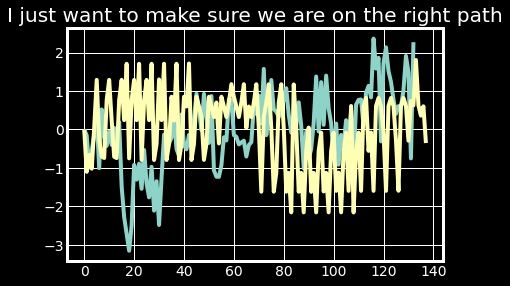

In [0]:
mean = np.mean(np.sum(processed, axis=1))
std = np.std(np.sum(processed, axis=1))
normalized = (np.sum(processed, axis=1) - mean) / std

plt.plot(input_data)
plt.plot(normalized.tolist())
plt.title('I just want to make sure we are on the right path')